# Forecasting crime in NYC

In [316]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import LabelEncoder

path = 'C:/Users/Zaca/Documents/Datasets/nyc/'

In [284]:
crime = pd.read_csv(path + 'nypd_historic_07-18.csv', index_col=0)

C:\Users\Zaca\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [272]:
crime = crime.groupby('date').agg(count=('precinct','count')).reset_index()
crime = crime.set_index('date')
crime.index = pd.to_datetime(crime.index)

# Weekly seasonality

In [273]:
weekly = crime.resample('W').mean()

In [274]:
weekly.drop(weekly.tail(1).index, inplace=True)

In [275]:
weekly.tail()

,count
date,
2018-12-02,1157.142857
2018-12-09,1118.714286
2018-12-16,1116.000000
2018-12-23,1092.000000
2018-12-30,961.000000


## Calculate stationarity
- Using ADFuller test

ADF Statistic: -5.166263622815082
p-value: 1.029896366427829e-05
Critical Values:
	1%: -3.441115625417986
	5%: -2.866289751785392
	10%: -2.56929951625907


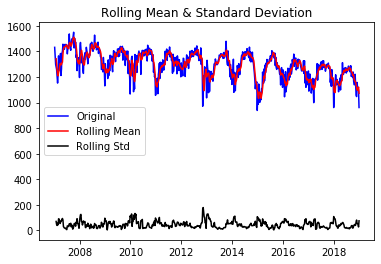

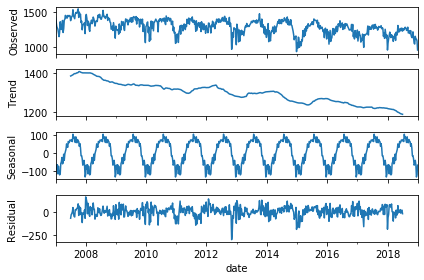

In [276]:
def get_stationarity(timeseries, window=4):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=window).mean()
    rolling_std = timeseries.rolling(window=window).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    
    decomposition = seasonal_decompose(timeseries)
    decomposition.plot();
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['count'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

get_stationarity(weekly)

- there is a strong seasonal component which is good!
- but there is also a trend :(

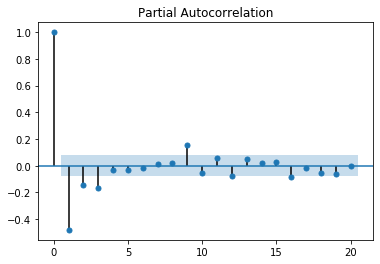

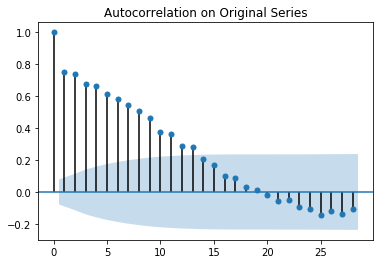

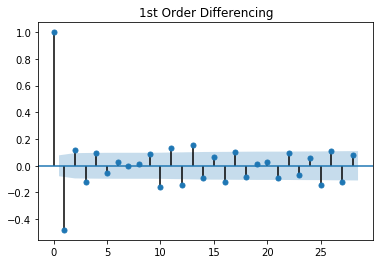

In [277]:
def auto_correlation(timeseries):

    fig = plot_pacf(timeseries.diff().dropna(), lags=20, title='Partial Autocorrelation')
    
    fig = plot_acf(timeseries, title="Autocorrelation on Original Series") 
    fig = plot_acf(timeseries.diff().dropna(), title="1st Order Differencing")
    
auto_correlation(weekly)

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.count   No. Observations:                  624
Model:                 ARIMA(4, 2, 2)   Log Likelihood               -3466.472
Method:                       css-mle   S.D. of innovations             62.157
Date:                Sat, 14 Mar 2020   AIC                           6948.943
Time:                        22:33:22   BIC                           6984.433
Sample:                    01-21-2007   HQIC                          6962.734
                         - 12-30-2018                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0027      0.007     -0.389      0.698      -0.016       0.011
ar.L1.D2.count    -1.5207      0.061    -24.866      0.000      -1.641      -1.401
ar.L2.D2.count    -0.7959      0.075    -10.544      0.000      -0.944      -0.648
ar.L3.D2.count    -0.4162      0.071     -5.838      0.000      -0.556      -0.276
ar.L4.D2.count    -0.1903      0.040     -4.781      0.000      -0.268      -0.112
ma.L1.D2.count    -0.0573      0.050     -1.153      0.249      -0.155       0.040
ma.L2.D2.count    -0.9425      0.050    -18.956      0.000      -1.040      -0.845
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1721           -0.0000j            1.1721           -0.5000
AR.2           -1.3202           -0.0000j            1.3202           -0.5000
AR.3            0.1527           -1.8364j            1.8428           -0.2368
AR.4            0.1527           +1.8364j            1.8428            0.2368
MA.1            1.0001           +0.0000j            1.0001            0.0000
MA.2           -1.0609           +0.0000j            1.0609            0.5000
-----------------------------------------------------------------------------
"""

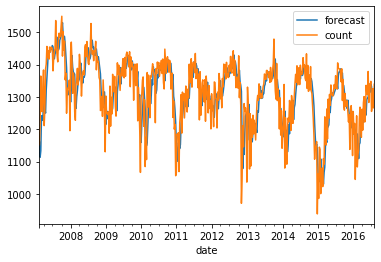

In [317]:
model = ARIMA(weekly, order=(4,2,2))
results = model.fit(disp=-1)

results.plot_predict(6,500);
results.summary()



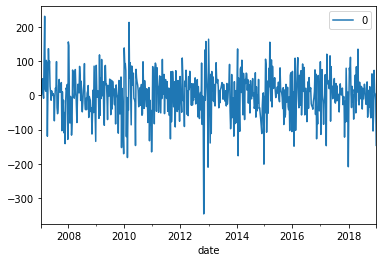

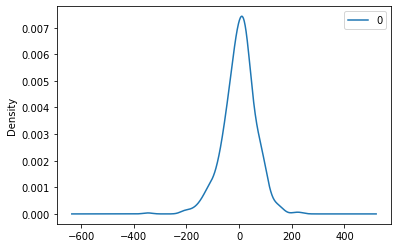

                0
count  624.000000
mean     1.294284
std     62.593806
min   -346.591399
25%    -33.016019
50%      6.548950
75%     38.573947
max    231.337542


In [318]:
residuals = pd.DataFrame(results.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [321]:
X = weekly.values
size = int(len(X) * 0.75)   # Split percentage

train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(4,2,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

Test MSE: 42.482


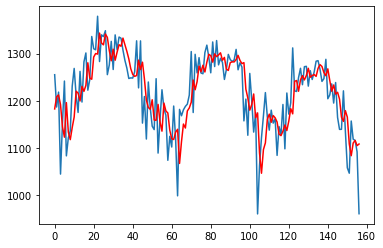

In [322]:
from sklearn.metrics import mean_absolute_error
error = mean_absolute_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
#plt.ylim(0, 160)
plt.show()

In [323]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(test, predictions)

3.5875316658126892

# Clustering

In [324]:
crime

,date,time,precinct,class_code,description,level,borough,premises,geo
0,2008-04-10,19,73,341,PETIT LARCENY,MISDEMEANOR,BROOKLYN,STREET,"(40.669413836, -73.91260308)"
1,2007-06-03,15,28,236,DANGEROUS WEAPONS,MISDEMEANOR,MANHATTAN,STREET,"(40.801978284, -73.945511151)"
2,2010-02-16,20,102,105,ROBBERY,FELONY,QUEENS,GROCERY/BODEGA,"(40.699990268, -73.830977746)"
3,2009-11-10,16,79,341,PETIT LARCENY,MISDEMEANOR,BROOKLYN,FOOD SUPERMARKET,"(40.681004729, -73.955034577)"
5,2011-06-23,20,81,118,DANGEROUS WEAPONS,FELONY,BROOKLYN,STREET,"(40.678337995, -73.925577614)"
...,...,...,...,...,...,...,...,...,...
6847939,2015-08-23,2,75,340,FRAUDS,MISDEMEANOR,BROOKLYN,STREET,"(40.672269995, -73.875569231)"
6847940,2013-06-15,11,32,578,HARRASSMENT 2,VIOLATION,MANHATTAN,RESIDENCE - PUBLIC HOUSING,"(40.829882139, -73.9367581)"
6847941,2012-07-12,14,49,106,FELONY ASSAULT,FELONY,BRONX,STREET,"(40.846592354, -73.852913364)"
6847942,2012-04-15,19,112,341,PETIT LARCENY,MISDEMEANOR,QUEENS,STREET,"(40.728720422, -73.853512684)"


In [325]:
test = crime.loc[crime.precinct == 75, ['geo', 'time', 'level', 'date', 'description', 'premises']]

In [326]:
test['geoloc'] = test['geo'].str.replace('(','').str.replace(')', '').str.split(', ')

In [327]:
test.drop(labels='geo', axis=1, inplace=True)

In [328]:
test['latitude'] = test['geoloc'].apply(lambda x: x[0]).astype('float64')
test['longitude'] = test['geoloc'].apply(lambda x: x[1]).astype('float64')

In [329]:
test.drop(labels='geoloc', axis=1, inplace=True)

In [334]:
test['date'] = pd.to_datetime(test['date'])

In [341]:
test['dow'] = test['date'].apply(lambda x: x.weekday())
test.drop(labels='date', axis=1, inplace=True)

In [346]:
le = LabelEncoder()
label_cols = ['description', 'premises', 'level']
test[label_cols] = test[label_cols].apply(le.fit_transform)


In [347]:
test

,time,level,description,premises,latitude,longitude,dow
12,18,0,5,33,40.675399,-73.881119,4
57,21,1,4,33,40.652763,-73.886284,2
126,22,0,4,33,40.677273,-73.891477,0
160,21,1,15,33,40.687886,-73.869453,6
206,1,0,5,33,40.674830,-73.893673,5
...,...,...,...,...,...,...,...
6847810,19,1,0,33,40.671644,-73.863361,5
6847899,22,1,14,27,40.671247,-73.866094,5
6847911,3,0,20,33,40.672651,-73.867414,6
6847915,18,1,0,29,40.667221,-73.893645,0


# DBScan

In [349]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
scaler = StandardScaler()
features_std = scaler.fit_transform(test)

# Create meanshift object
cluster = DBSCAN(eps=0.5)

# Train model
model = cluster.fit(features_std)

# Show cluster membership
model.labels_

array([ 0,  1,  2, ..., 24, 31,  6], dtype=int64)

In [354]:
test['db_labels'] = model.labels_
test.db_labels.value_counts()

-1      18620
 1       8748
 9       8541
 12      8494
 5       8427
        ...  
 391        3
 262        3
 227        3
 332        2
 745        2
Name: db_labels, Length: 755, dtype: int64

In [352]:
from sklearn.metrics import silhouette_score


preds = cluster.fit_predict(test)

score = silhouette_score (features, preds, metric='euclidean')
print (f"For n_clusters = {n_clusters}, silhouette score is {score})")

KeyboardInterrupt: 

In [388]:
from sklearn.cluster import KMeans

test = test[['latitude', 'longitude']]

# Standardize features
scaler = StandardScaler()
features_std = scaler.fit_transform(test)

# we can put this all in a for loop and just evaluate.

# Create k-mean object
n_clusters = 7
cluster = KMeans(n_clusters=n_clusters, random_state=0, n_jobs=-1)

# Train model
model = cluster.fit(test)

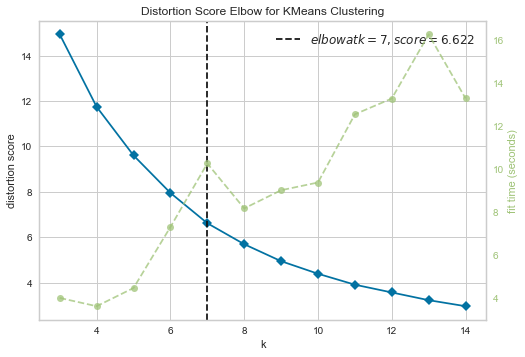

In [387]:
# Elbow
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,15))
visualizer.fit(test)
visualizer.poof()

In [389]:
test['klabels'] = model.labels_

In [390]:
test.groupby('klabels').count()

,latitude,longitude
klabels,,
0,33944,33944
1,26844,26844
2,25210,25210
3,28338,28338
4,9170,9170
5,28335,28335
6,35125,35125


(-73.91, -73.86)

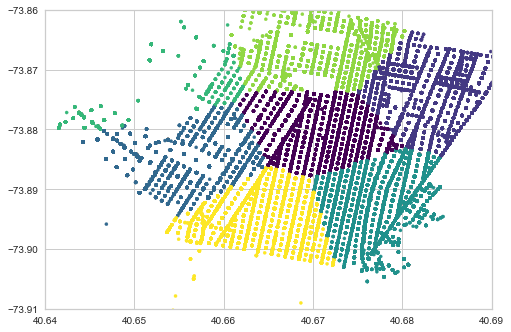

In [394]:
plt.scatter(test.latitude, test.longitude, c= test.klabels, cmap='viridis', s=10)
plt.xlim(40.64, 40.69)
plt.ylim(-73.91, -73.86)

In [371]:
from sklearn.metrics import silhouette_score


preds = cluster.fit_predict(test)

score = silhouette_score (test, preds, metric='euclidean')
print (f"For n_clusters = {n_clusters}, silhouette score is {score})")

KeyboardInterrupt: 

In [385]:
test[test.klabels==3]['time'].describe()

count    40216.000000
mean        15.504252
std          1.111012
min         14.000000
25%         15.000000
50%         15.000000
75%         16.000000
max         17.000000
Name: time, dtype: float64

In [395]:
test = crime.loc[crime.precinct == 75, ['geo', 'time', 'level', 'date', 'description', 'premises']]

In [396]:
test.description.value_counts()

ASSAULT 3 & RELATED OFFENSES      24850
PETIT LARCENY                     22278
HARRASSMENT 2                     21194
DANGEROUS DRUGS                   20204
CRIMINAL MISCHIEF & RELATED OF    18116
GRAND LARCENY                     10654
FELONY ASSAULT                    10004
OFF. AGNST PUB ORD SENSBLTY &      9582
ROBBERY                            8813
MISCELLANEOUS PENAL LAW            7771
DANGEROUS WEAPONS                  5646
BURGLARY                           5578
GRAND LARCENY OF MOTOR VEHICLE     3544
OFFENSES AGAINST PUBLIC ADMINI     3531
SEX CRIMES                         2357
INTOXICATED & IMPAIRED DRIVING     2179
VEHICLE AND TRAFFIC LAWS           2141
FORGERY                            2094
FRAUDS                             1465
THEFT-FRAUD                        1347
CRIMINAL TRESPASS                  1243
POSSESSION OF STOLEN PROPERTY      1111
RAPE                                652
UNAUTHORIZED USE OF A VEHICLE       432
OFFENSES INVOLVING FRAUD            180
